<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [113]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from matplotlib.ticker import FuncFormatter

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [136]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

def corr_heatmap(data, method = "pearson"):
    # Set the default matplotlib figure size:
    mean_corr = data.corr(method = method)
    
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like( mean_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(mean_corr, ax=ax,  square = True, mask=mask, linecolor='white', annot = True, cmap='RdBu', vmin=-1, vmax=1, fmt = '.2f')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()
    
def currency(x, pos):
    return '${:1.0f}K'.format(x*1e-3)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [137]:
# Load the data taking "Id" as the index column: house
house = pd.read_csv("housing.csv", index_col = "Id")

In [138]:
# Creates mask to split into training and test accoring to YrSold to be used for later: mask_train, mask_test
mask_train = house["YrSold"] != 2010
mask_test = house["YrSold"] == 2010

---

**Keeping only the residential houses in the dataset**

---

In [139]:
# Creates a list of MsZoning to keep: residential
residential = ["RH", "RL", "RP", "RM", "FV"]
# Removes the other c
house = house[house["MSZoning"].isin(residential)]

---

**Exploring the dataset - Predictors**

---

In [140]:
#Shape
print("The dimensions of the Ames housing dataset is {}".format(house.shape))

The dimensions of the Ames housing dataset is (1450, 80)


In [141]:
#Header Names
house.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

In [142]:
#Data Types
house.dtypes[0:10]

MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
Street          object
Alley           object
LotShape        object
LandContour     object
Utilities       object
LotConfig       object
dtype: object

In [143]:
# Missing Values
missing = house.isnull().sum()
missing[missing != 0].sort_values(ascending = False)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageYrBlt       79
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

---

We can see that there is quite a bit of missing data which would need cleaning.

From the categories that have missing data, we are going to fill them with either "None" or "na" depending on if the category is of numeric type or categorical type. 

In each case the variable is checked with the data dictionary to ensure that it makes sense for it to be None/Na

The only exceptions to this are Electrical and LotFrontage in which case we are going to fill in with values that make sense.

---

In [144]:
#Categorical Variables with missing data: missing_categoricals
missing_categoricals = ["PoolQC", "MiscFeature", "Fence", "FireplaceQu", "GarageYrBlt", "GarageType", "GarageFinish",\
                       "GarageQual", "GarageCond", "BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual",
                       "MasVnrType", "Alley"]

#Numerical Variables with missing data: missing_numerics
missing_numerics = ["MasVnrArea"]

#Fills all categorical missing values with "None"
for category in missing_categoricals:
    house[category].fillna("None", inplace = True)
    
#Fills all numerical missing values with "0"
for category in missing_numerics:
    house[category].fillna(0, inplace = True)
    
#Fills missing Electrical value with mode "SBrkr"
house["Electrical"].fillna(str(house["Electrical"].mode()), inplace = True)

#Fills missing LotFrontage values with the median in the neighborhood
house["LotFrontage"].fillna(house.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())), inplace = True)

In [145]:
#Asserts that there are no more missing values
missing = house.isnull().sum()
missing[missing != 0].sort_values(ascending=False)

Series([], dtype: int64)

---

Looking at the correlation map of the dataset we can see there are a few points that have strong correlations with each other, for example:

**GarageCars vs GarageArea**

**1stFlrSF vs TotalBsmtSF**

We will look into removing these correlation issues via introducing various transformations.

---

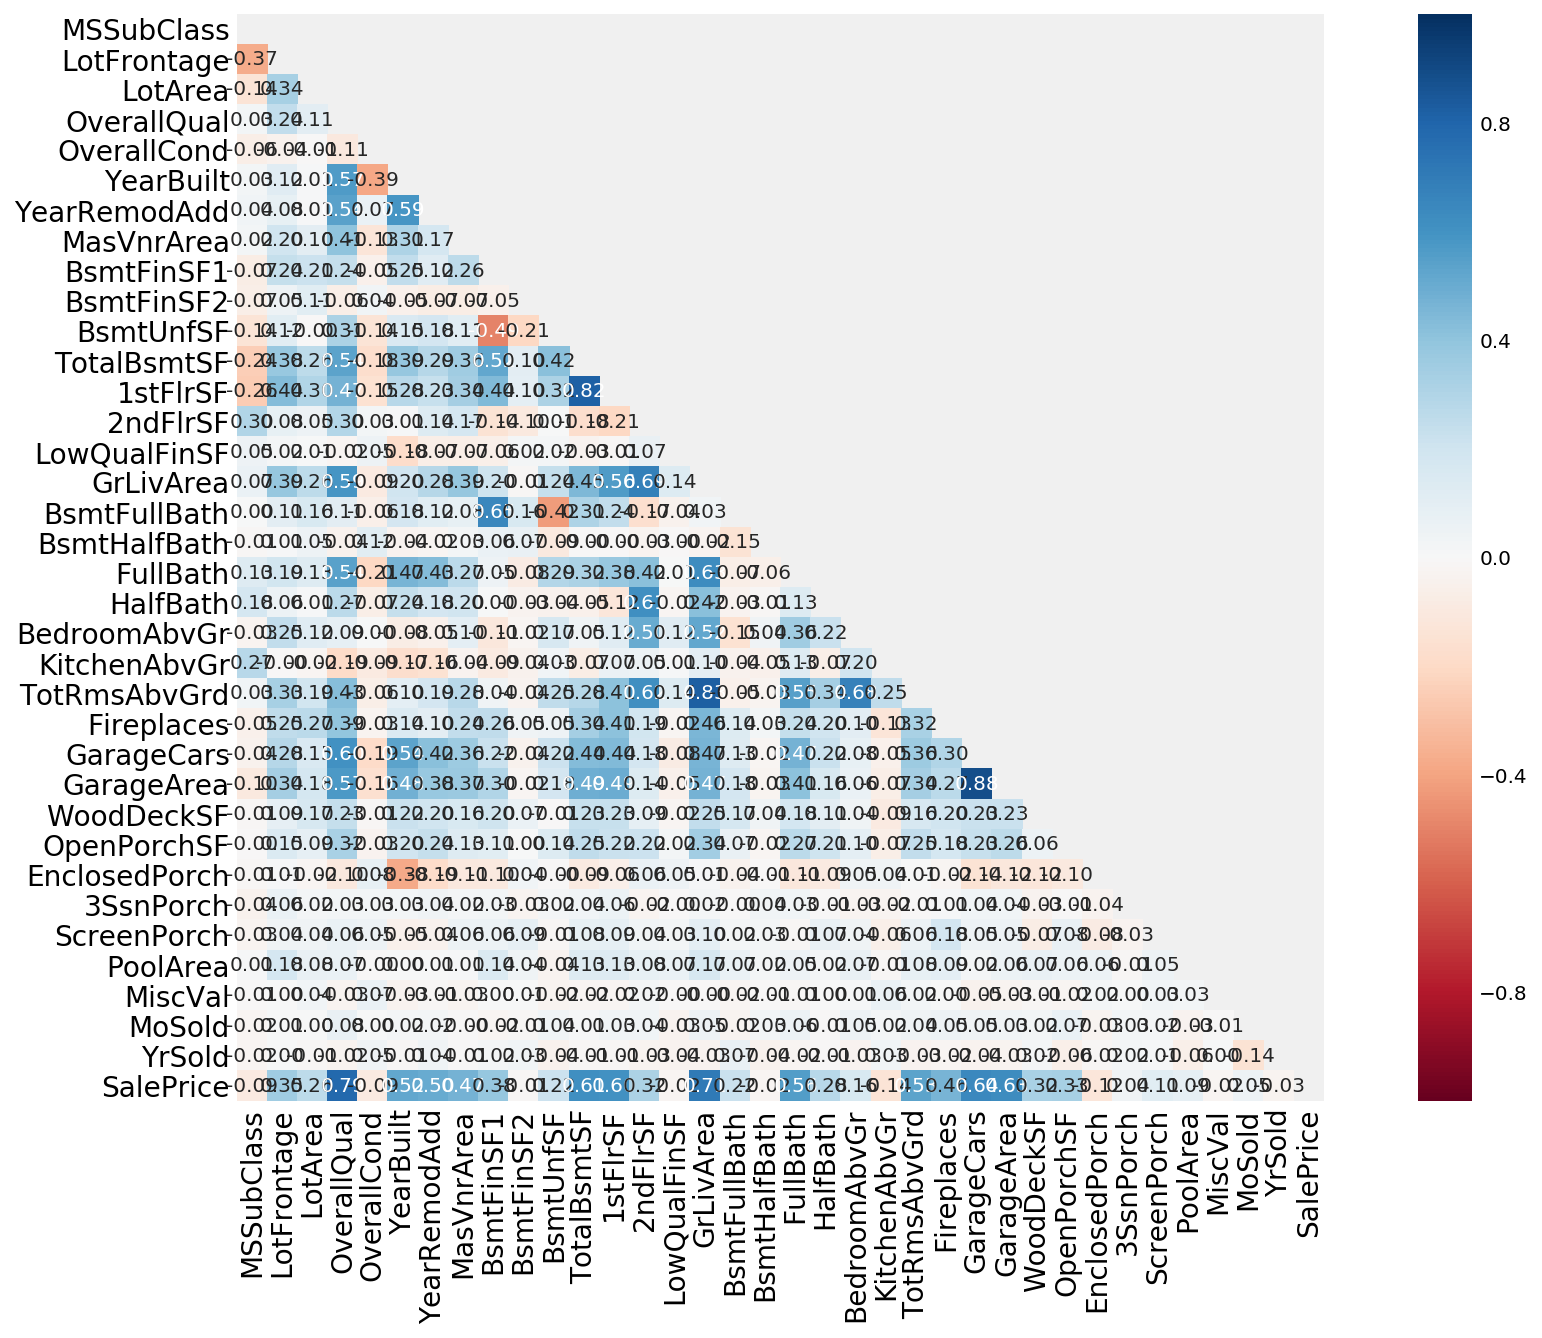

In [146]:
corr_heatmap(house)

---

** Modifying Variables**

There are few variables that can be modified to be more intuitive. These are "YearBuilt", "YearRemodAdd", "Neighborhood",
and Surface Area of house.

YearBuilt and YearRemodAdd are changed into Age where age is defined to be 2010 minus their respective years.

Surface Area is created to remove the strong correlations between surface area of other aspects as visualised in the correlation heatmap.

---

In [87]:
#Creates a new column: house["Age"]
house["Age"] = house["YearBuilt"].map(lambda x: 2010 - x)

#Creates a new column: house["Remod_Age"]
house["Remod_Age"] = house["YearRemodAdd"].map(lambda x: 2010 - x)

#Creates a new column: house["Total_SF"]
house["Total_SF"] = house["TotalBsmtSF"] + house["1stFlrSF"] + house["2ndFlrSF"]

---

** Exploring Sale Price**


---

In [88]:
#Taking out the training dataset: house_train
house_train = house[mask_train]

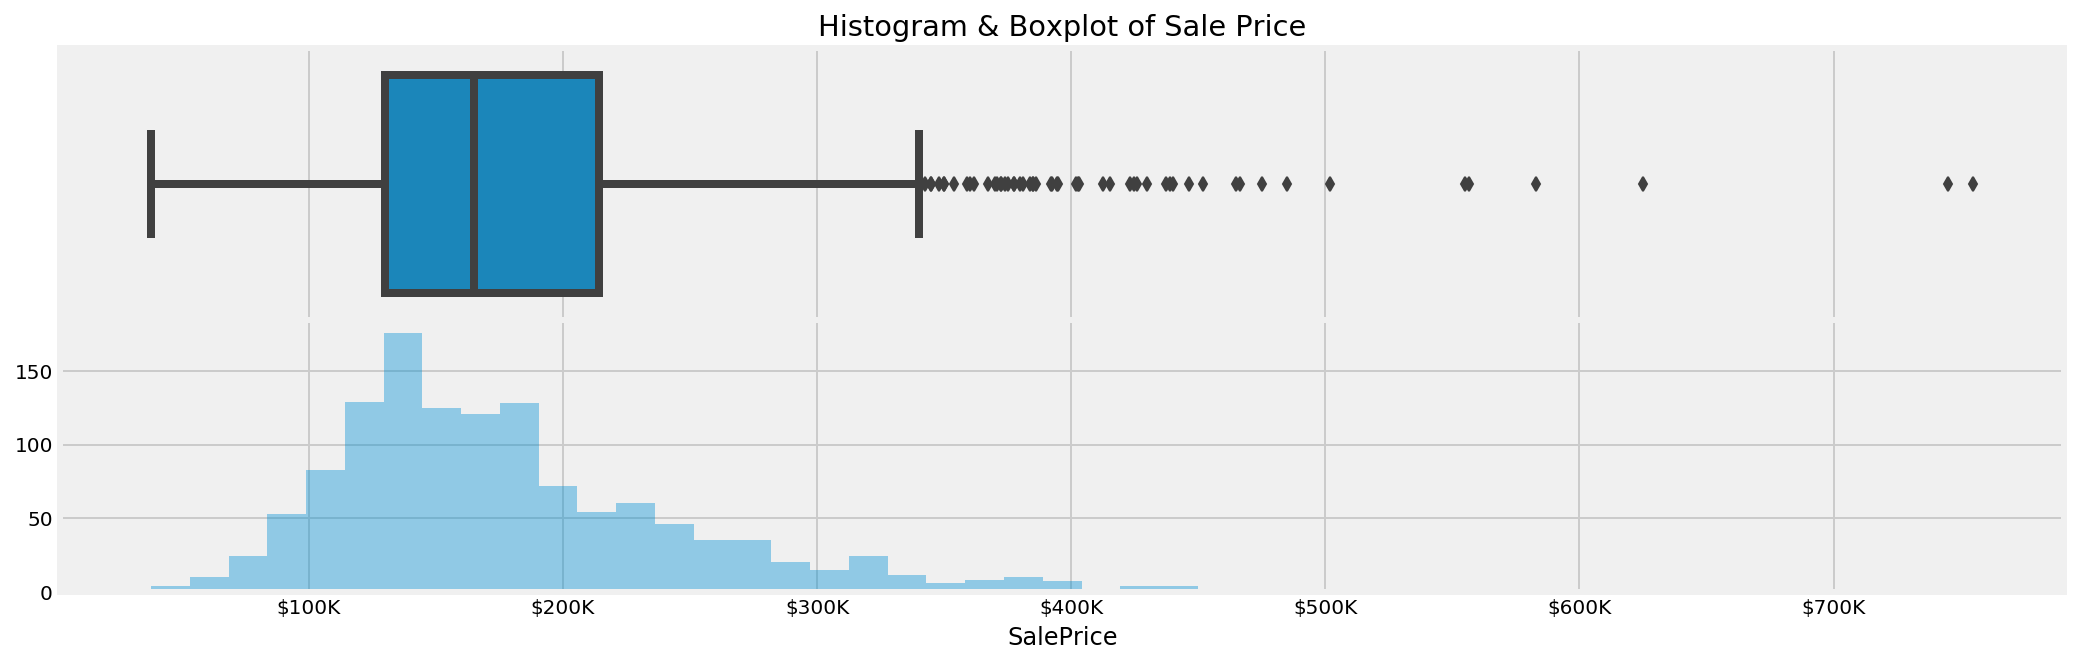

In [89]:
fig, ax = plt.subplots(2, sharex = True, figsize = (16,5))
ax[0] = sns.boxplot(house_train["SalePrice"], ax = ax[0])
ax[1] = sns.distplot(house_train["SalePrice"],kde = False, ax = ax[1])

formatter = FuncFormatter(currency)
ax[1].xaxis.set_major_formatter(formatter)

ax[0].set_title("Histogram & Boxplot of Sale Price")
fig.subplots_adjust(hspace=0)

plt.show()

---
**Dropping Outliers**

We can see that there are considerable outliers in the dataset so we're going to look into removing any outliers from out training dataset that have a SalePrice greater than $500k.

---

In [90]:
mask_outliers = (house_train[house_train["SalePrice"] >= 500000] == True).index
print("The dimensions of the dataset before dropping ouliers is {}".format(house.shape))

house.drop(mask_outliers, inplace = True)
print("The dimensions of the dataset after dropping ouliers is {}".format(house.shape))

#Reset the mask for the training set
mask_train = house["YrSold"] != 2010
mask_test = house["YrSold"] == 2010

The dimensions of the dataset before dropping ouliers is (1450, 83)
The dimensions of the dataset after dropping ouliers is (1443, 83)


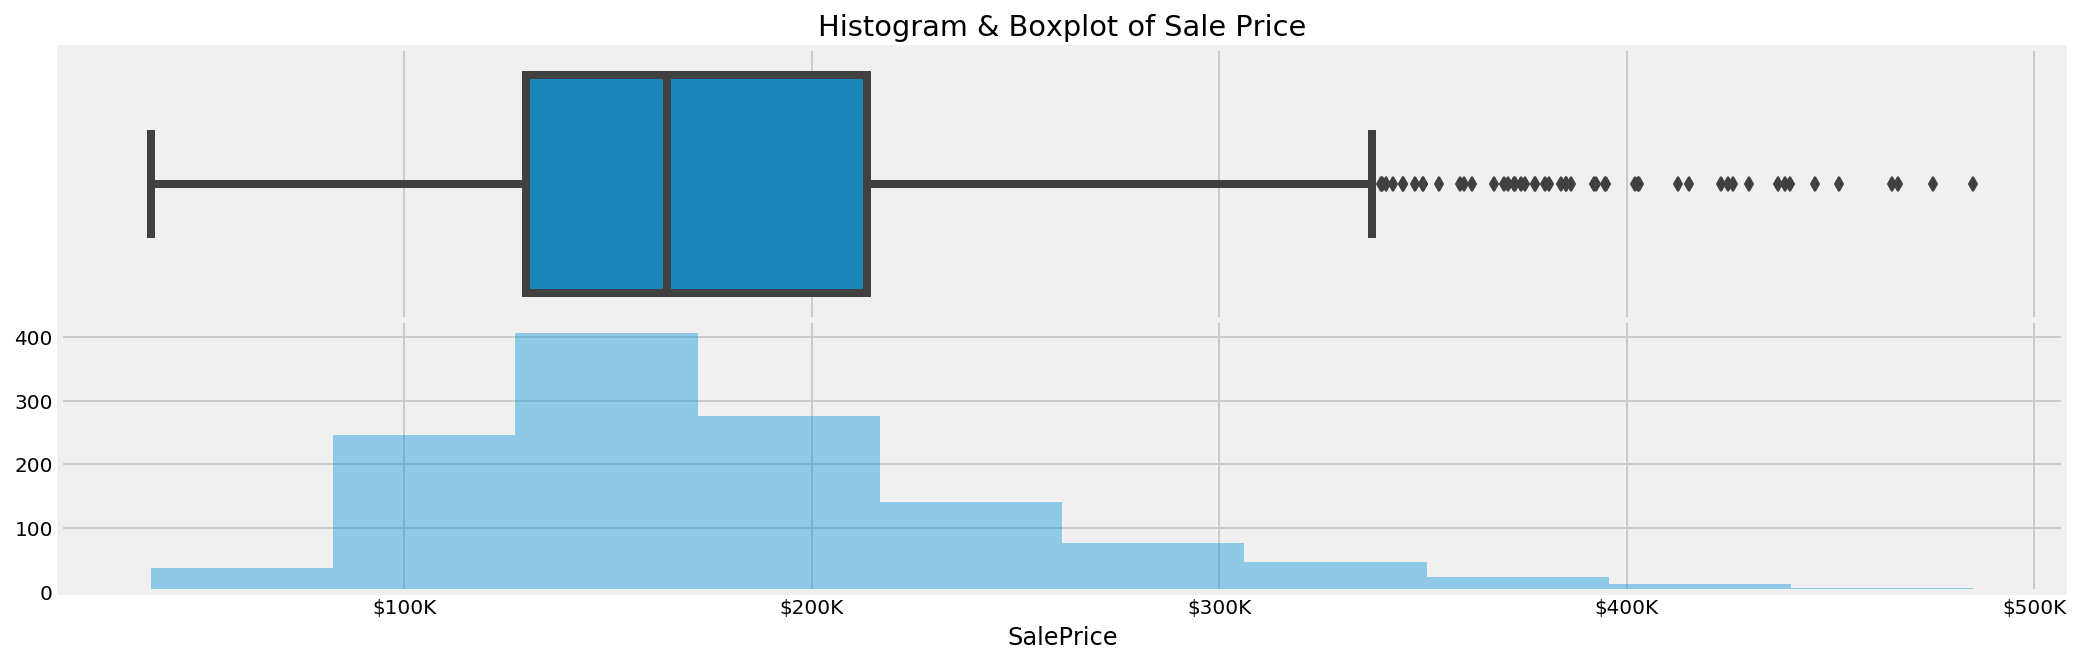

In [91]:
house_train = house[mask_train]

fig, ax = plt.subplots(2, sharex = True, figsize = (16,5))
ax[0] = sns.boxplot(house_train["SalePrice"], ax = ax[0])
ax[1] = sns.distplot(house_train["SalePrice"],kde = False, ax = ax[1], bins = 10)

formatter = FuncFormatter(currency)
ax[1].xaxis.set_major_formatter(formatter)

ax[0].set_title("Histogram & Boxplot of Sale Price")
fig.subplots_adjust(hspace=0)

plt.show()

---
**Log Transforming**

Since there is still evident skew in the SalesPrice we look to log transform the SalePrice to be more normally distributed, and adding the column to the dataset

---

In [92]:
house["LogSalePrice"] = np.log(house["SalePrice"])
house.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,Remod_Age,Total_SF,LogSalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,208500,7,7,2566,12.247694
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,181500,34,34,2524,12.109011
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,223500,9,8,2706,12.317167


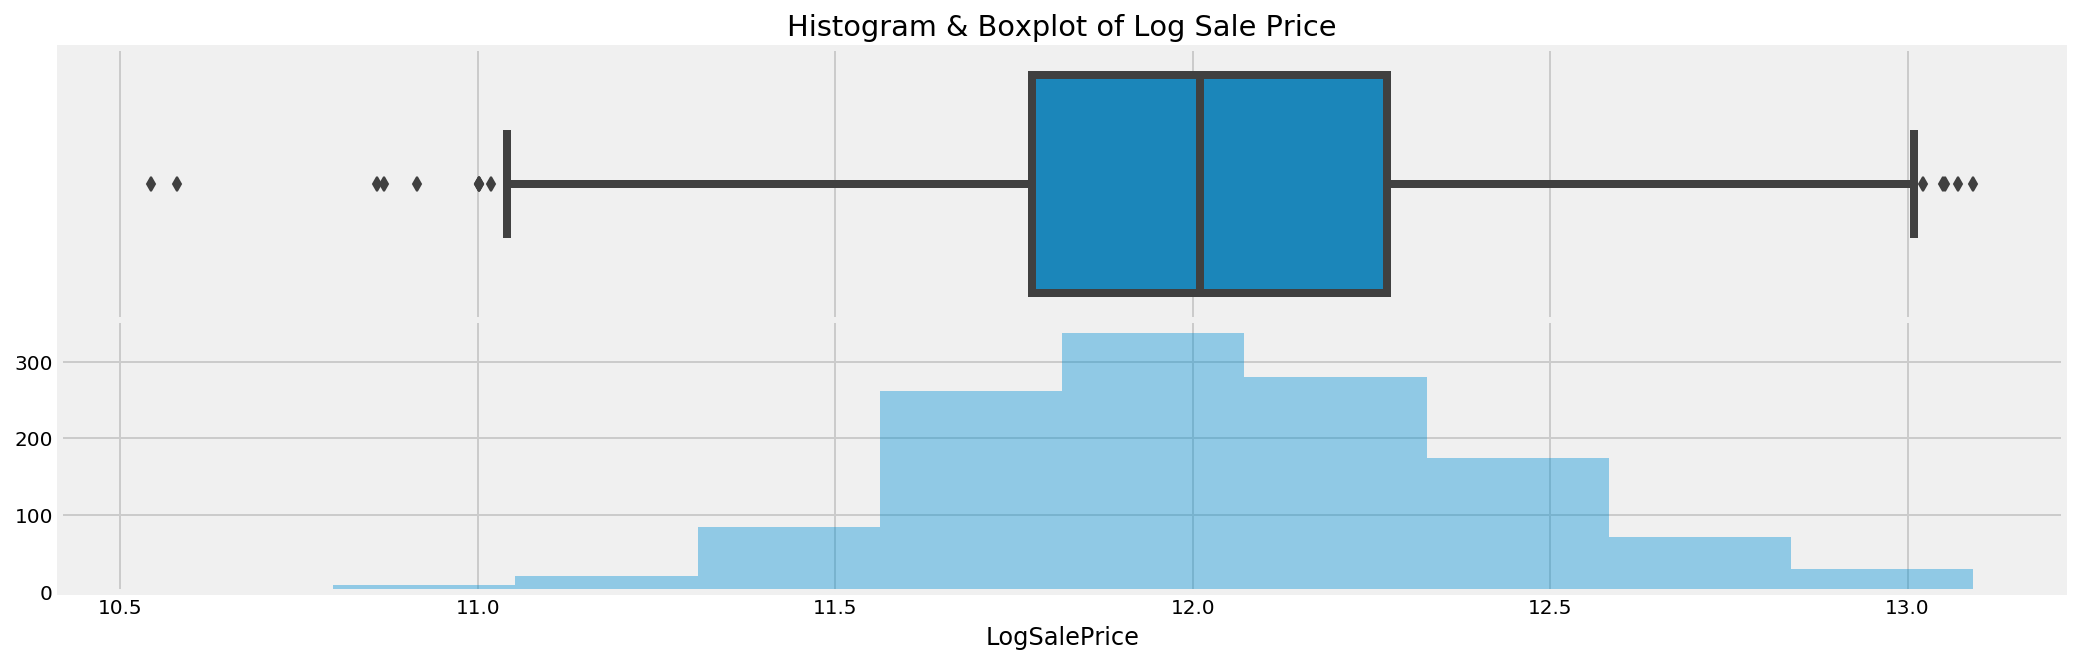

In [93]:
house_train = house[mask_train]

fig, ax = plt.subplots(2, sharex = True, figsize = (16,5))
ax[0] = sns.boxplot(house_train["LogSalePrice"], ax = ax[0])
ax[1] = sns.distplot(house_train["LogSalePrice"],kde = False, ax = ax[1], bins = 10)

ax[0].set_title("Histogram & Boxplot of Log Sale Price")
fig.subplots_adjust(hspace=0)

plt.show()

---

** Exploring Sale Price against Fixed Categorical Variables**

Lets look at some relationships between SalePrice and Fixed Categorical Variables.

A few to note:

* Neighborhood
* Alley
* BldgType
* MSSubClass
* Street
* LotShape
* LandContour
* LotConfig
* LandSlope
* Condition1
* Condition2

---

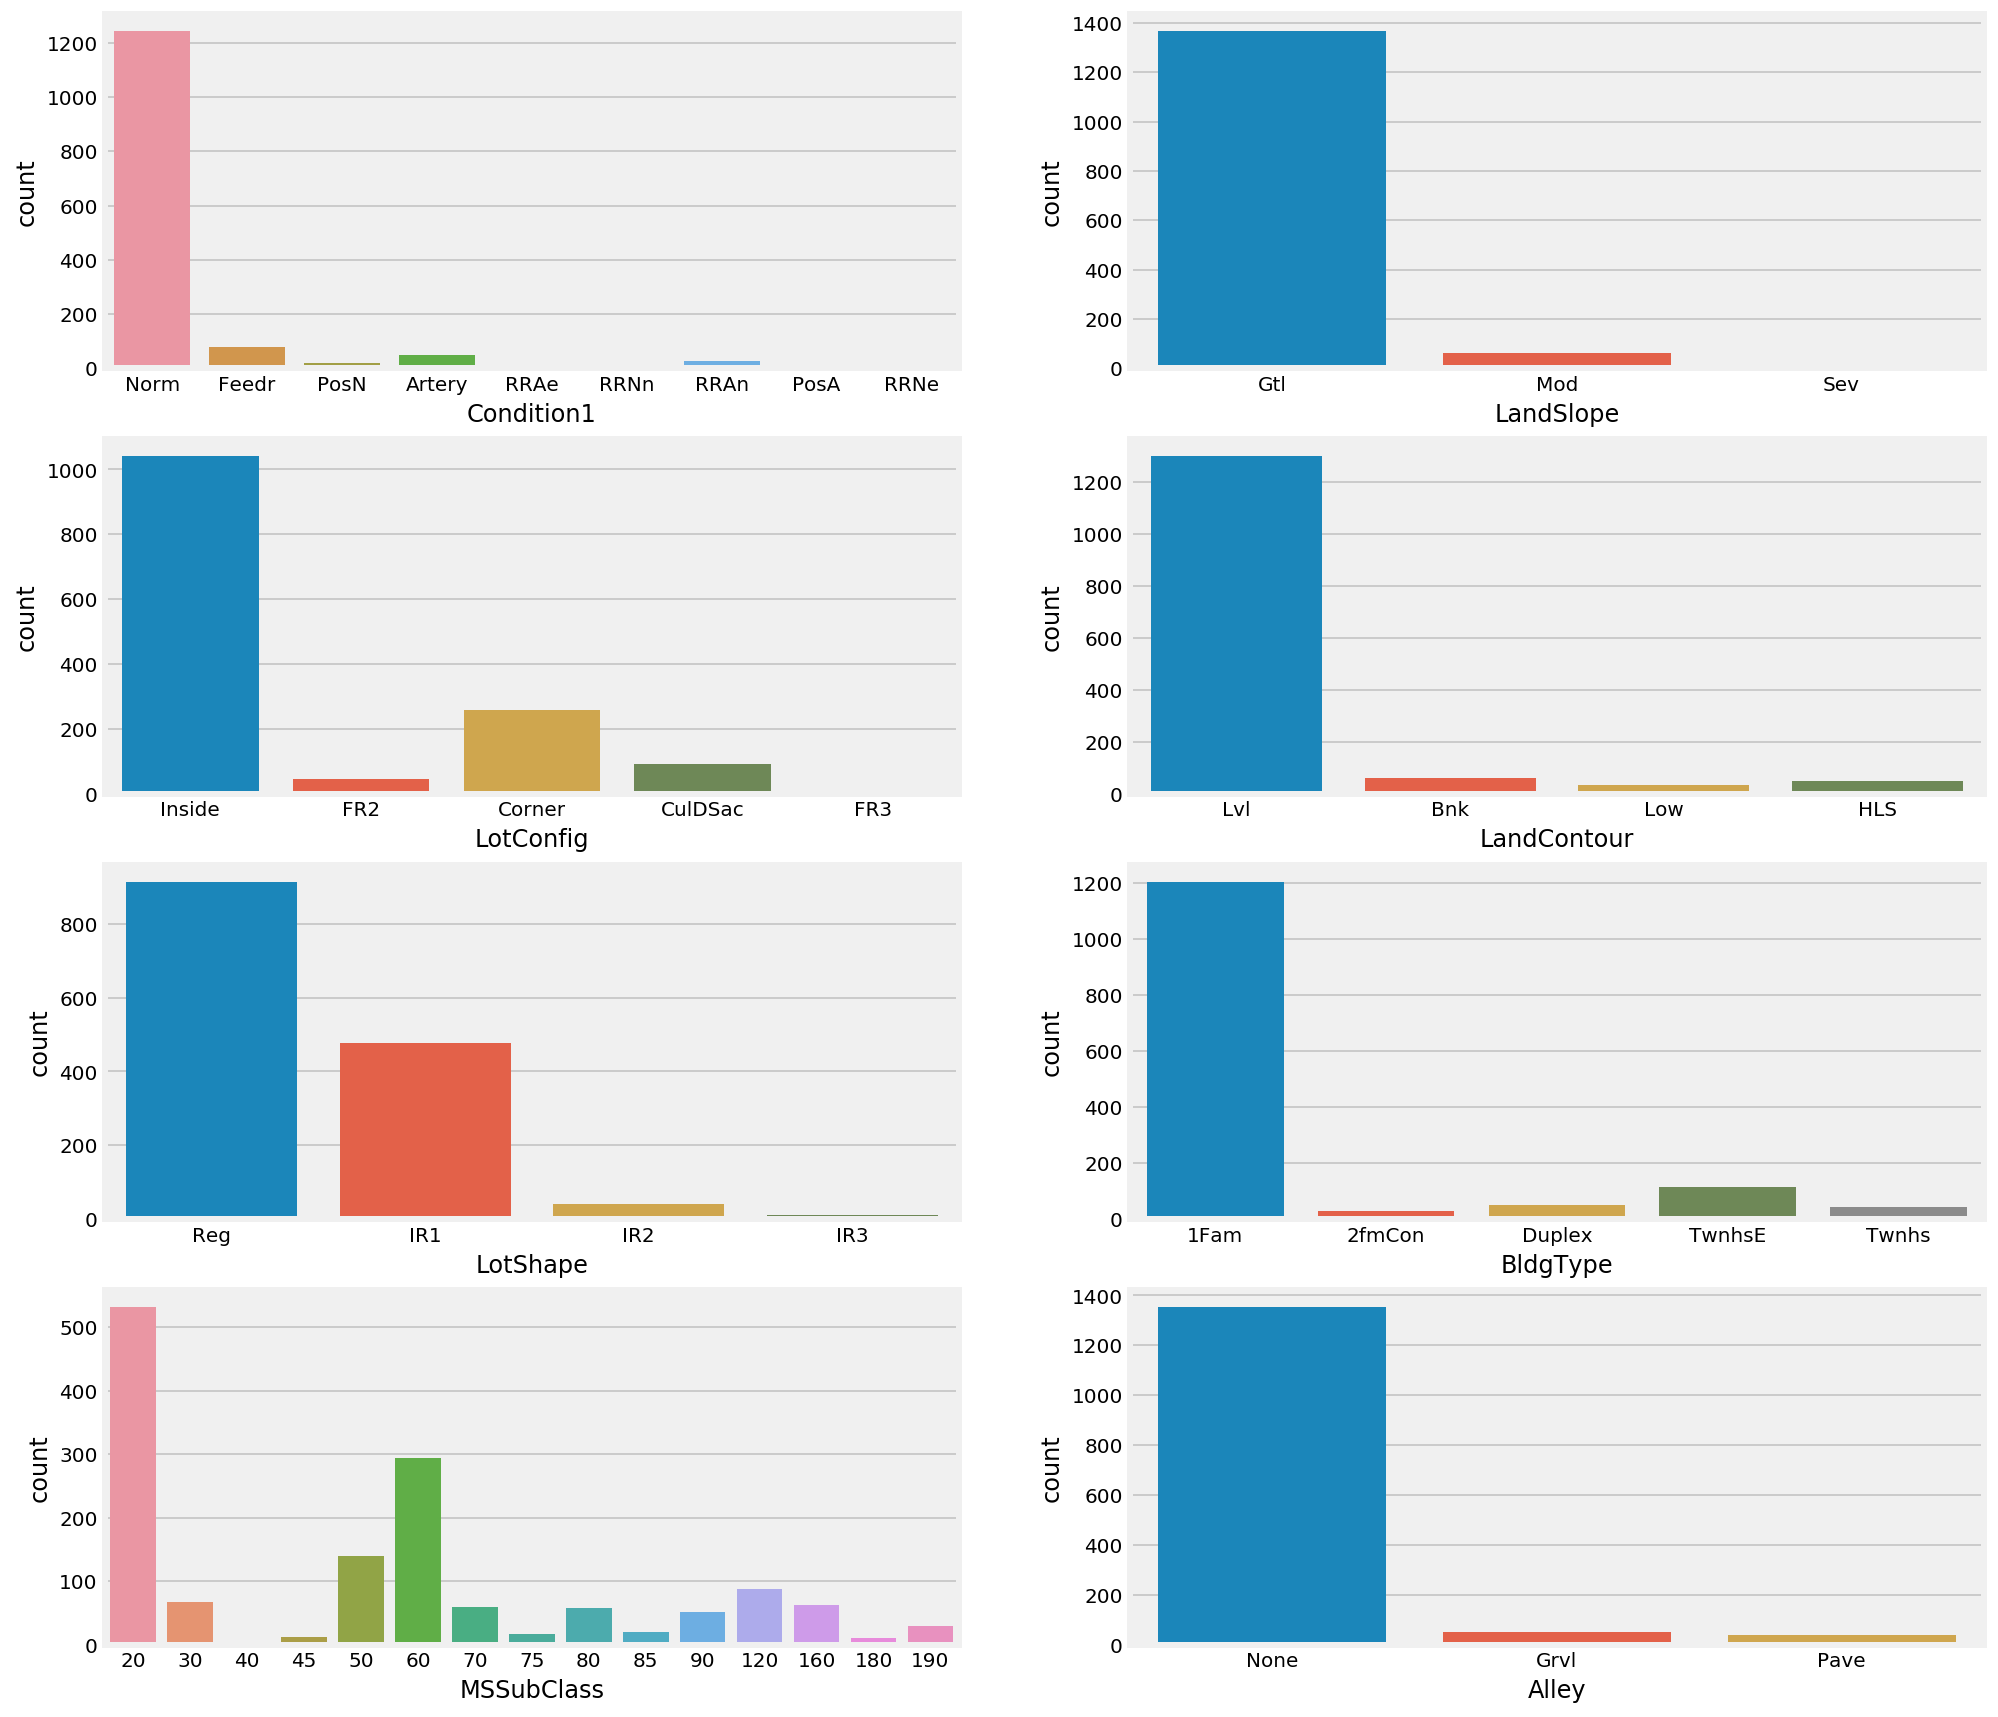

In [94]:
#Plots the counts of each
fixed_categoricals = ["Alley", "MSSubClass", "BldgType", "LotShape", "LandContour", "LotConfig", "LandSlope", "Condition1"]

fig, ax = plt.subplots(int(len(fixed_categoricals)/2),2, figsize = (15,15))

ax = ax.flatten()
for i in range(len(fixed_categoricals)):
    ax[i] = sns.countplot(house[fixed_categoricals.pop()], ax = ax[i])


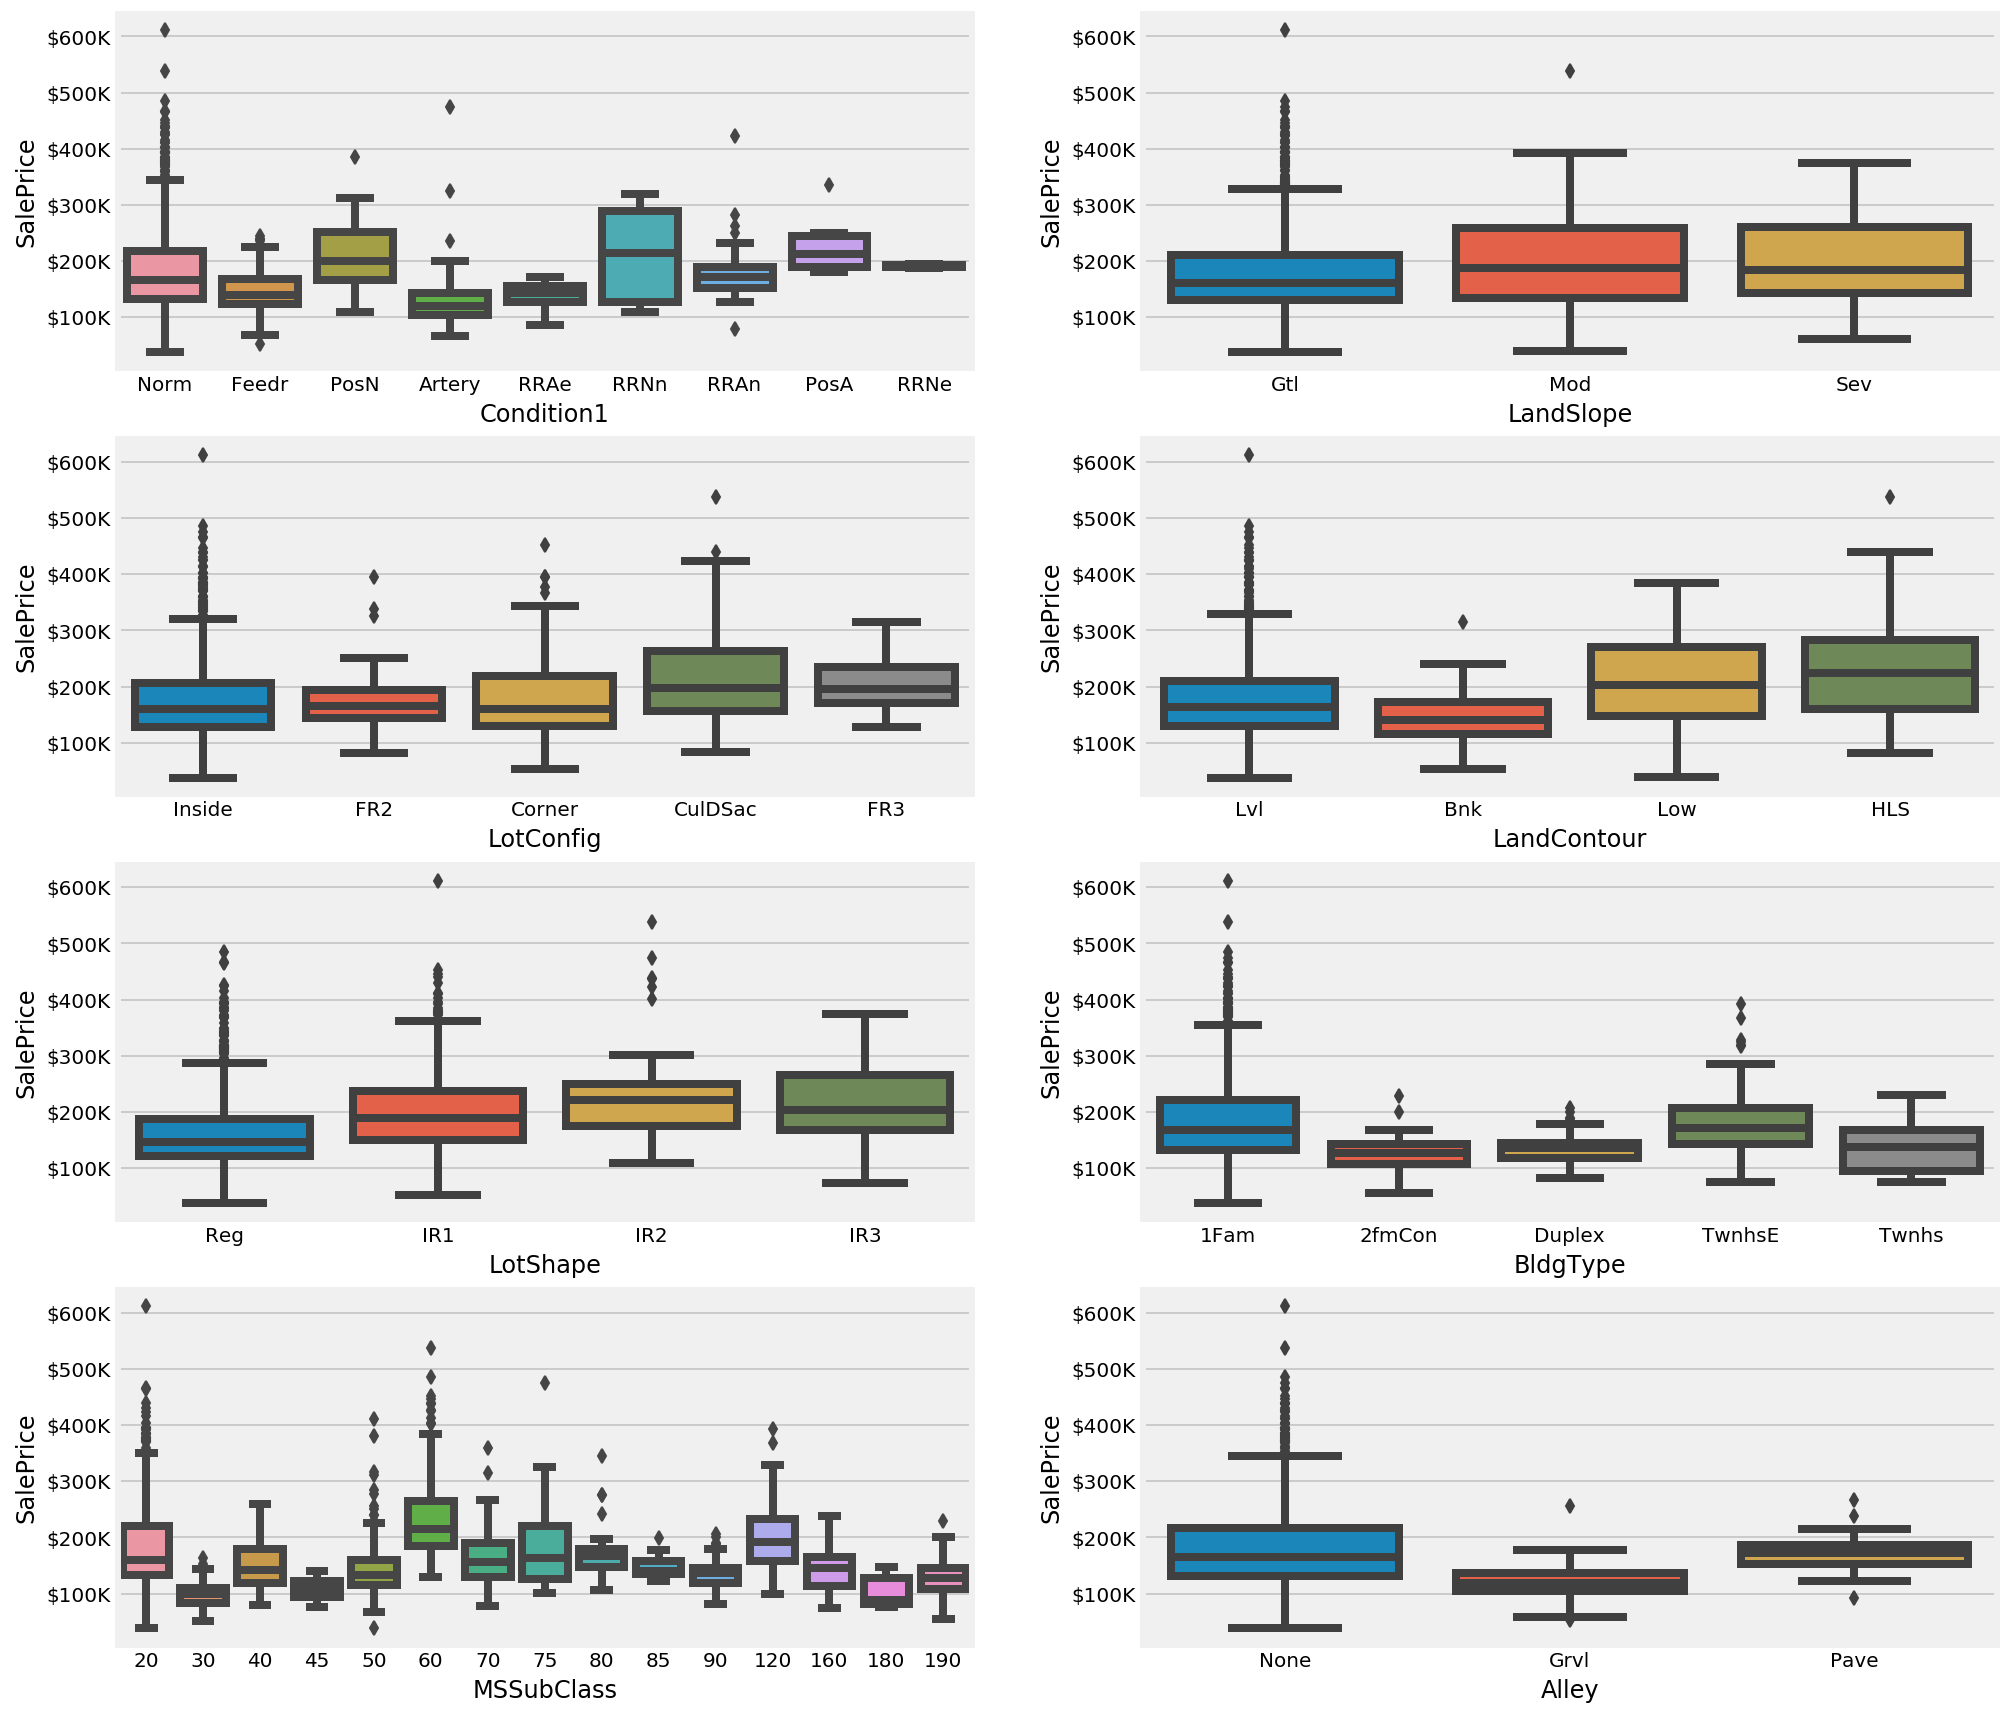

In [95]:
#Plots the boxplot of each against SalePrice
fixed_categoricals = ["Alley", "MSSubClass", "BldgType", "LotShape", "LandContour", "LotConfig", "LandSlope", "Condition1"]

fig, ax = plt.subplots(int(len(fixed_categoricals)/2),2, figsize = (15,15))

ax = ax.flatten()
for i in range(len(fixed_categoricals)):
    ax[i] = sns.boxplot(x = house[fixed_categoricals.pop()], y =house["SalePrice"], ax = ax[i])
    formatter = FuncFormatter(currency)
    ax[i].yaxis.set_major_formatter(formatter)


---

** Exploring Sale Price against Neighborhood**

And finally against Neighborhood

---

In [104]:
#Groups the data by Neighboorhood and takes the Median of the SalePrices: neighborhood_prices
neighborhood_prices = house.loc[:, ["SalePrice", "Neighborhood"]].groupby(by = "Neighborhood").median().sort_values(by = "SalePrice", ascending = False)

#Creates a new column that stores the median price of the neighborhood for each house: "NeighborhoodPrice"
house["NeighborhoodPrice"] = [neighborhood_prices.loc[x,"SalePrice"] for x in house["Neighborhood"]]

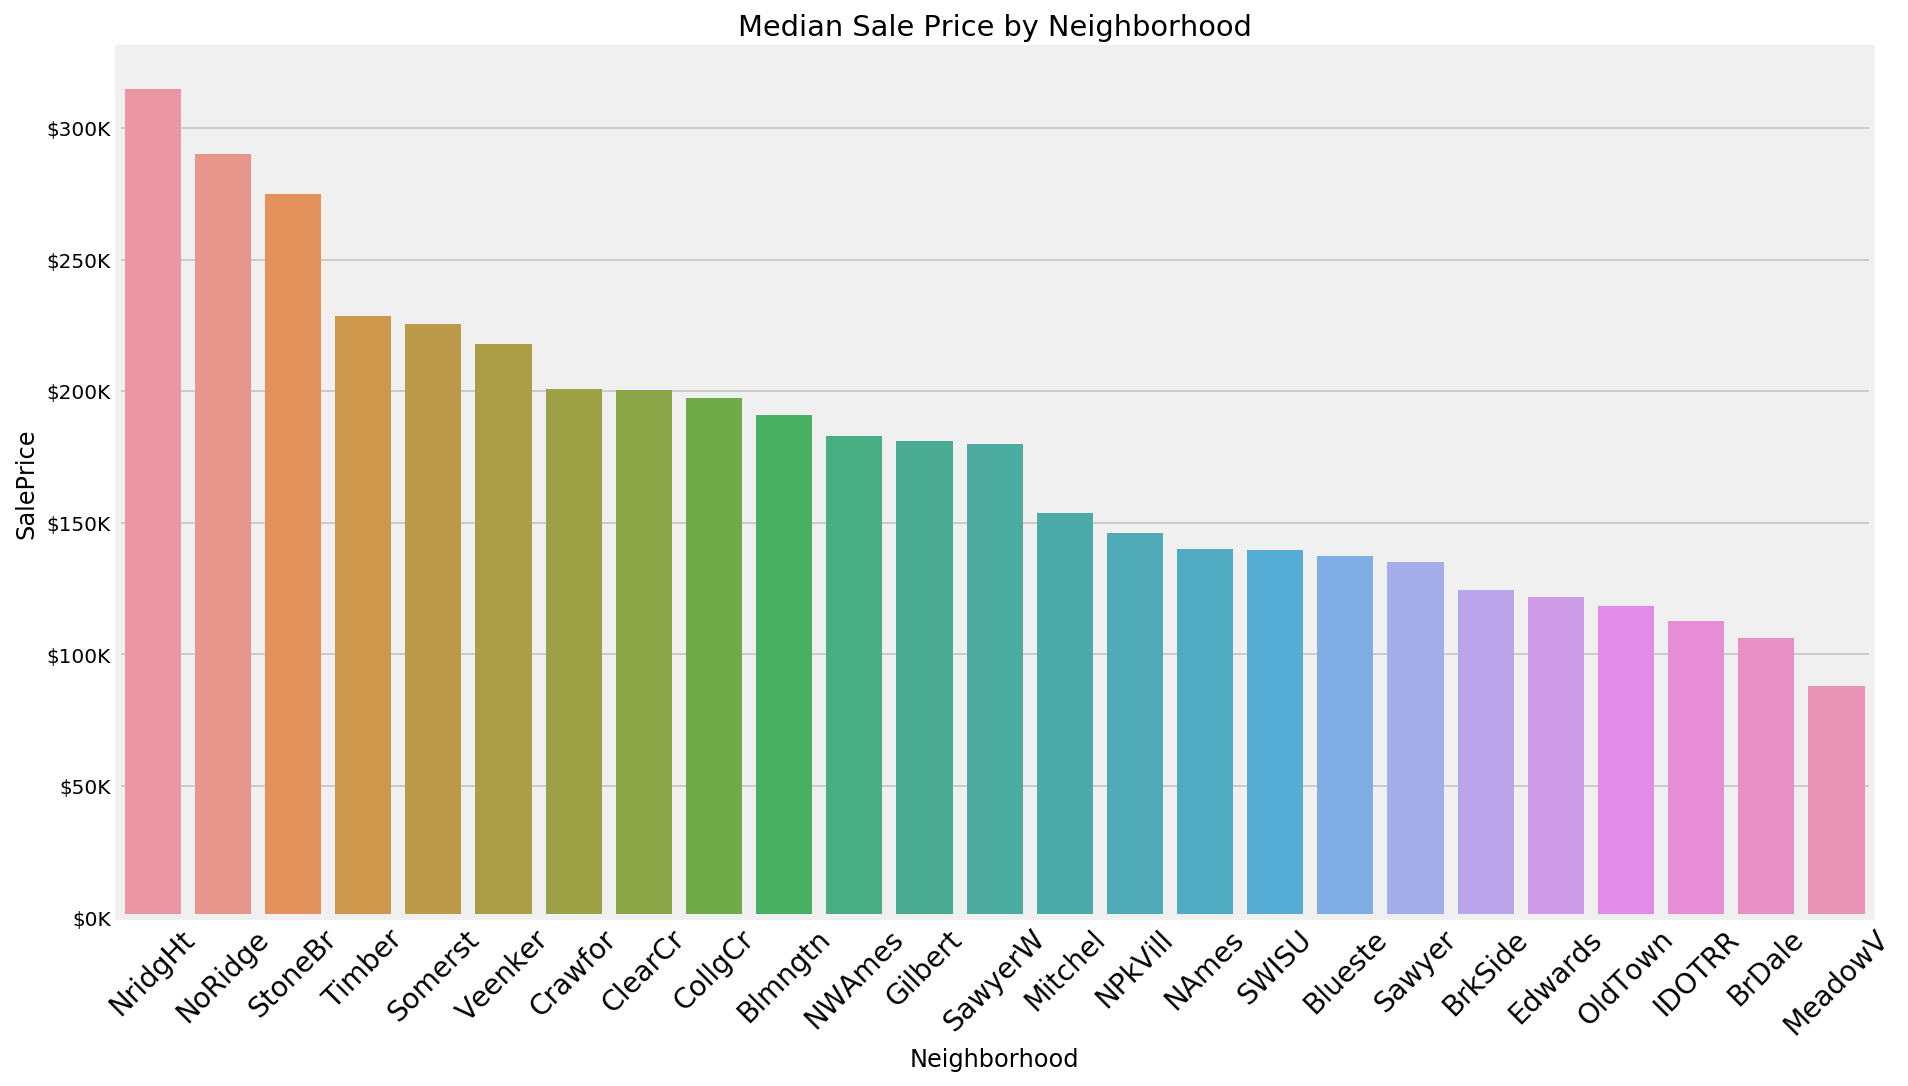

In [97]:
#SalePrice against Neighborhood
fig, ax = plt.subplots(figsize = (14,8))

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title("Median Sale Price by Neighborhood")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)


ax = sns.barplot(x = neighborhood_prices.index, y = "SalePrice", data = neighborhood_prices)



### Splitting the dataset and regressing on fixed variables

In [107]:
#Splitting after standardise
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Splitting after standardize with Patsy
fix_feat = '~ BsmtFinSF1 + GrLivArea + FullBath + TotRmsAbvGrd + Fireplaces + GarageArea + WoodDeckSF +\
            Total_SF + NeighborhoodPrice + C(Condition1) + C(BldgType) + C(LotShape) + Age -1'

X = patsy.dmatrix(fix_feat, data=house, return_type='dataframe')
y = house["LogSalePrice"]

ss = StandardScaler()
Xs = ss.fit_transform(X)

Xs_train = Xs[mask_train]
Xs_test = Xs[mask_test]

y_train = y[mask_train]
y_test = y[mask_test]

slr = LinearRegression()

model = slr.fit(Xs_train, y_train)

print("The R-squared score of the training dataset is: {:.2f}%".format(model.score(Xs_train,y_train)*100))
print("The R-squared score of the testing dataset is: {:.2f}%".format(model.score(Xs_test,y_test)*100))

yfixed_testpreds = model.predict(Xs_test)
yfixed_trainpreds = model.predict(Xs_train)

print("--------------------------------------------------------")
print("The RMSE of the training set is {:.2f}".format(np.sqrt(mean_squared_error(y_train, yfixed_trainpreds))))
print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(y_test, yfixed_testpreds))))

The R-squared score of the training dataset is: 82.01%
The R-squared score of the testing dataset is: 86.77%
--------------------------------------------------------
The RMSE of the training set is 0.16
The RMSE of the testing set is 0.14


In [1]:
import statsmodels.formula.api as smf

fix_feat_smf = "LogSalePrice" + fix_feat

results = smf.ols(fix_feat_smf, data=house).fit()
results.summary()

NameError: name 'fix_feat' is not defined

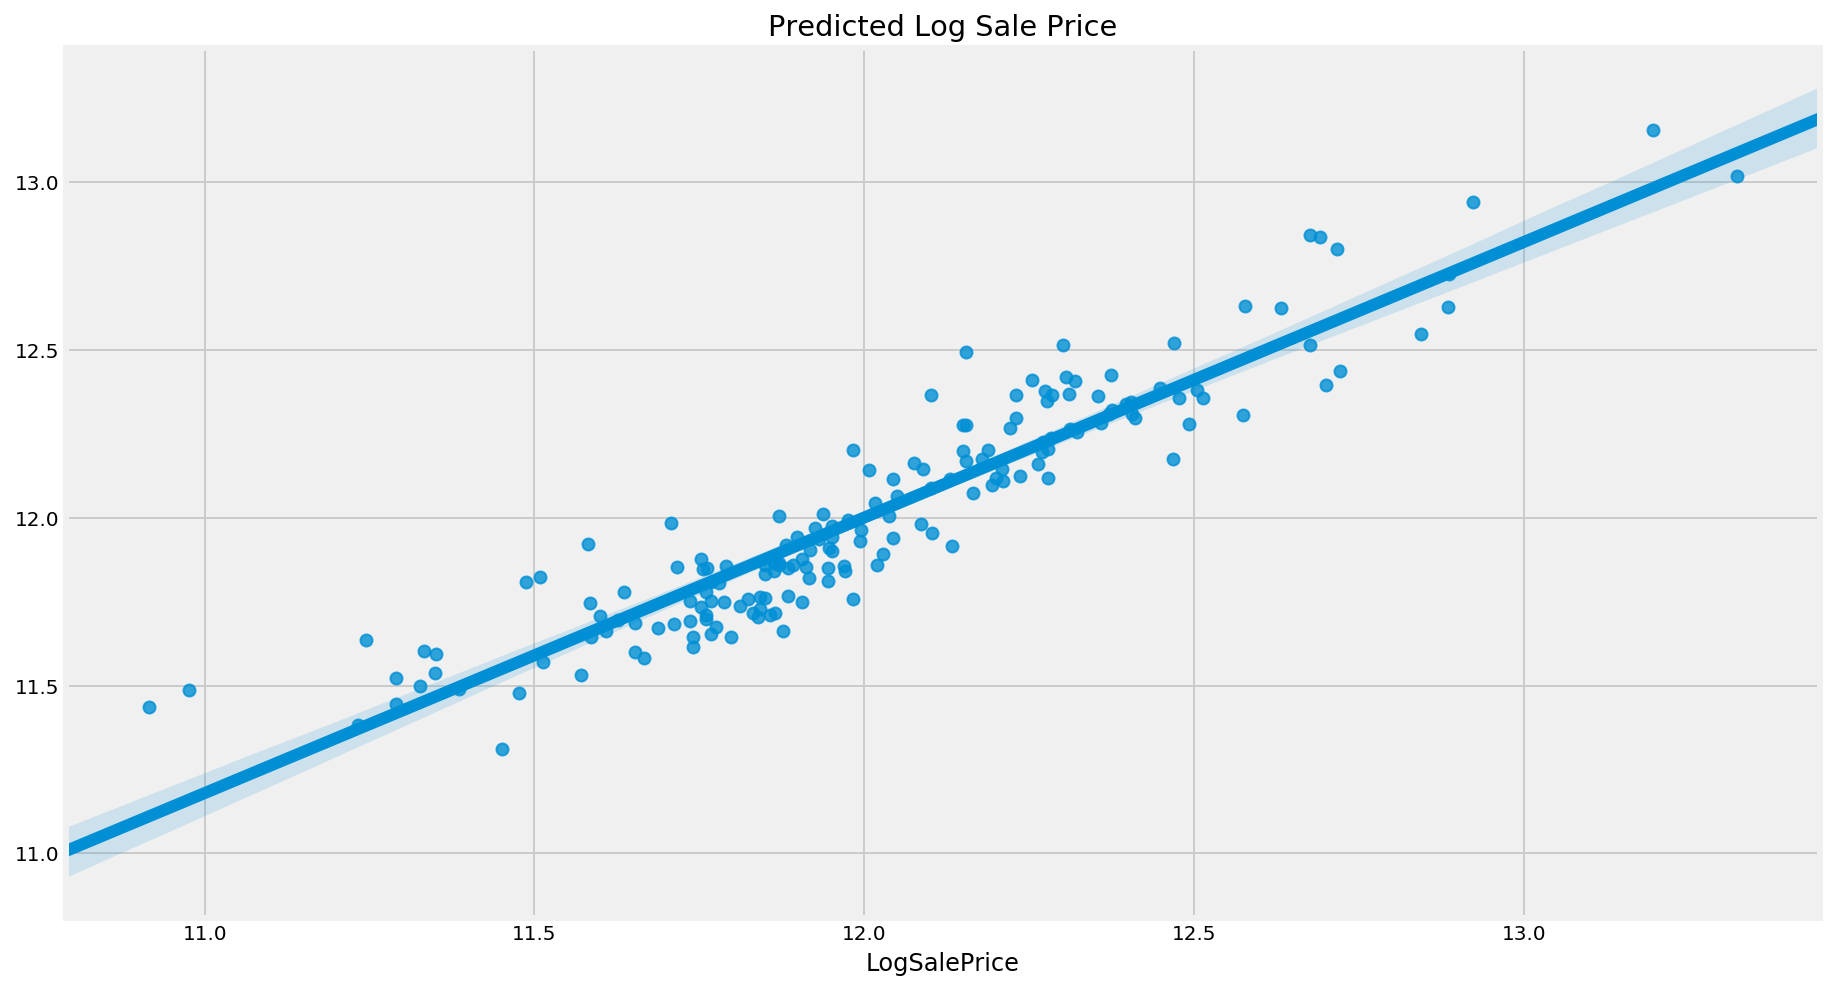

The RMSE of the testing set is 0.14


In [147]:
#SalePrice against Neighborhood
fig, ax = plt.subplots(figsize = (14,8))

ax.set_title("Cross Validation Predications against actual Log Sale Price Values")
ax.set_xlabel("Actual Log Sale Price")
ax.set_title("Predicted Log Sale Price")

ax = sns.regplot(y_test, yfixed_testpreds)

plt.show()

print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(y_test, yfixed_testpreds))))

Part 1 - Conclusion
---

---

Under a basic Cross Validated Simple Linear Regression Model with 10 folds, the model is able to explain 86.17% of the variances (**R-Squared**).

Furthermore the predictions did fairly well against the actual log prices with an RMSE of only 0.15 for the testing model, not too far off the 0.17 for training.

In Part 2, we will look into trying to explain more of the variations using simple methods

---

In [28]:
%store house
%store mask_train
%store mask_test
%store fix_feat

Stored 'house' (DataFrame)
Stored 'mask_train' (Series)
Stored 'mask_test' (Series)
Stored 'fix_feat' (str)
